In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import csv

import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imba_make_pipeline, Pipeline as ImbaPipeline
from joblib import dump, load

import spacy

In [2]:
data = pd.read_csv("ai-ethics.tsv", sep="\t")
data

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0,0.0,0,0.383240
1,abs1910.02390,2019-10-06,1.0,0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1,0.0,0,0.379631
2,abs1405.1605,2014-05-07,1.0,0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1,0.0,0,0.300291
3,abs1907.04534,2019-07-10,1.0,1,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1,1.0,1,0.733579
4,abs1906.04272,2019-06-10,1.0,1,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1,0.0,1,0.592441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,abs1712.03073,2017-12-01,NaN,0,Enabling Cooperative Inference of Deep Learnin...,Deep Learning (DL) algorithm is the state-of-t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.302998
1421,abs1805.10318,2018-05-25,NaN,1,Enhancing the Accuracy and Fairness of Human D...,Societies often rely on human experts to take ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.671577
1422,abs1410.6277,2014-10-23,NaN,0,The Probabilistic Structure of Discrete Agent-...,This paper describes a formalization of agent-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.386153
1423,abs1806.00793,2018-06-03,NaN,0,Transfer Topic Labeling with Domain-Specific K...,Topic models are widely used in natural langua...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.419378


In [6]:
ai_index_ethics_keywords = [
    ['ethic'],
    ['ethics'],
    ['ethical'],
    ['moral'],
    ['morality'],
    ['sustainability'],
    ['racist'],
    ['racism'],
    ['machine', 'bias'],
    ['unemployment'],
    ['employment'],
    ['workforce'],
    ['humanity'],
    ['humane'],
    ['fool'],
    ['fooling'],
    ['fooled'],
    ['security'],
    ['secure'],
    ['sentient'],
    ['sentience'],
    ['rights'],
    ['law'],
    ['society'],
    ['responsibility'],
    ['accountability'],
    ['accountable'],
    ["privacy"],
]

In [7]:
def ai_index_is_ethics( text, kws ):
    qty = 0
    for kw in kws:
        has = True
        for k in kw:
            if k not in text:
                has = False
                break
            #end if
        #end for
        if has:
            qty += 1
        #end if
    return qty
#end check

In [14]:
ai_index_pred = []
for doc in data.description:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)
    
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, ai_index_pred))

confusion_matrix [[986 131]
 [157 151]]
f1_score 0.511864406779661
precision_score 0.5354609929078015
recall_score 0.4902597402597403
accuracy_score 0.7978947368421052
roc_auc_score 0.6864906579544


In [15]:
human_labeled_data = data[data['is_ethics %'].notna()]

ai_index_pred = []
for doc in human_labeled_data.description:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, ai_index_pred))

confusion_matrix [[181  19]
 [ 49  41]]
f1_score 0.5466666666666666
precision_score 0.6833333333333333
recall_score 0.45555555555555555
accuracy_score 0.7655172413793103
roc_auc_score 0.6802777777777778


In [72]:
ai_index_pred = []
for doc in data.title:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)
    
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, ai_index_pred))

confusion_matrix [[1082   35]
 [ 256   52]]
f1_score 0.26329113924050634
precision_score 0.5977011494252874
recall_score 0.16883116883116883
accuracy_score 0.7957894736842105
roc_auc_score 0.5687486193305352


In [73]:
human_labeled_data = data[data['is_ethics %'].notna()]

ai_index_pred = []
for doc in human_labeled_data.title:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, ai_index_pred))

confusion_matrix [[196   4]
 [ 77  13]]
f1_score 0.24299065420560748
precision_score 0.7647058823529411
recall_score 0.14444444444444443
accuracy_score 0.7206896551724138
roc_auc_score 0.5622222222222222


In [3]:
nlp = spacy.load("en_core_web_lg")

In [82]:
abstracts = []
for doc in nlp.pipe(data.description):
    abstracts.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

titles = []
for doc in nlp.pipe(data.description):
    titles.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [93]:
vectorizer = CountVectorizer(
    max_df = 0.75,
    max_features = None,
    min_df = 2,
)
X = vectorizer.fit_transform(abstracts+titles)
X_abs = vectorizer.transform(abstracts)
X_ttl = vectorizer.transform(titles)

In [94]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, list(data.is_ethics)+list(data.is_ethics))

In [95]:
lg_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', LogisticRegression(
            penalty = "l1",
            solver = "liblinear",
            C = 1,
        )),
    ])

cross_val_score(lg_pipeline, X_resampled, y_resampled, cv=4, scoring = "roc_auc", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s finished


array([0.91190824, 0.92689476, 0.92118228, 0.91836083])

In [96]:
rf_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

cross_val_score(rf_pipeline, X_resampled, y_resampled, cv=4, scoring = "roc_auc", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.9s finished


array([0.99469728, 0.99820149, 0.99465577, 0.99794132])

In [97]:
lg_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', LogisticRegression(
            penalty = "l1",
            solver = "liblinear",
            C = 1,
        )),
    ])

In [148]:
lg_pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfTransformer(norm='l1', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [165]:
keywords_idx = [i for i,x in enumerate(lg_pipeline.named_steps["clf"].coef_[0,:]) if x>0]
antikeywords_idx = [i for i,x in enumerate(lg_pipeline.named_steps["clf"].coef_[0,:]) if x<0]
keywords_idx, antikeywords_idx, lg_pipeline.named_steps["clf"].intercept_

([624,
  893,
  1206,
  2772,
  3350,
  3570,
  3574,
  4133,
  4389,
  5011,
  5383,
  5476,
  5917,
  6929,
  7690,
  8342,
  8351,
  9253],
 [1131, 2414, 4737, 5710, 5866, 6091, 7202, 8637, 8856, 8927, 9072],
 array([-0.54504386]))

In [164]:
mapping = vectorizer.get_feature_names()

print([mapping[i] for i in keywords_idx])
print([mapping[i] for i in antikeywords_idx])

['ai', 'artificial', 'bias', 'discrimination', 'ethical', 'fair', 'fairness', 'group', 'human', 'issue', 'literature', 'machine', 'moral', 'portrait', 'research', 'social', 'society', 'trust']
['base', 'datum', 'information', 'method', 'model', 'network', 'propose', 'student', 'system', 'technique', 'time']


In [169]:
lemma_kws = set()
for kws in ai_index_ethics_keywords:
    kw = " ".join(kws)
    lemma_kws |= set(x.lemma_ for x in nlp(kw))
print(lemma_kws)

{'moral', 'morality', 'right', 'responsibility', 'secure', 'sentient', 'law', 'unemployment', 'accountability', 'ethic', 'bias', 'accountable', 'humane', 'sentience', 'privacy', 'society', 'fool', 'sustainability', 'racist', 'security', 'ethical', 'machine', 'racism', 'humanity', 'employment', 'workforce'}


In [98]:
rf_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

In [100]:
rf_pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfTransformer(norm='l1', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=512, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [101]:
X_title = vectorizer.transform([" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct) for doc in nlp.pipe(data.title)])

y_pred = rf_pipeline.predict(X_title)
y_prob = rf_pipeline.predict_proba(X_title)

In [105]:
print(""" Trained only on abstracts:
confusion_matrix [[1043   74]
 [ 130  178]]
f1_score 0.6357142857142858
precision_score 0.7063492063492064
recall_score 0.577922077922078
accuracy_score 0.8568421052631578
roc_auc_score 0.7558365984955062
""")

 Trained only on abstracts:
confusion_matrix [[1043   74]
 [ 130  178]]
f1_score 0.6357142857142858
precision_score 0.7063492063492064
recall_score 0.577922077922078
accuracy_score 0.8568421052631578
roc_auc_score 0.7558365984955062



In [103]:
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, y_pred))

confusion_matrix [[1028   89]
 [ 125  183]]
f1_score 0.6310344827586207
precision_score 0.6727941176470589
recall_score 0.5941558441558441
accuracy_score 0.8498245614035088
roc_auc_score 0.7572390680045111


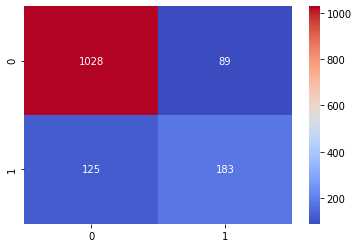

In [106]:
sns.heatmap(confusion_matrix(data.is_ethics, y_pred), annot=True, fmt="d", cmap="coolwarm")

In [58]:
aaai_data = pd.read_csv("aaai.txt", sep=";", quotechar="#", header=0, names=["year","id","title","authors","link","abstract"])
aaai_data = aaai_data[aaai_data["abstract"].notna()]

In [107]:
aaai_docs = []
for doc in nlp.pipe(aaai_data.abstract):
    aaai_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [108]:
aaai_X = vectorizer.transform(aaai_docs)
aaai_y_pred = rf_pipeline.predict(aaai_X)
aaai_y_prob = rf_pipeline.predict_proba(aaai_X)

In [109]:
aaai_data["is_ethics_with_ai"] = aaai_y_pred

In [69]:
aaai_ai_index_pred = []
for doc in aaai_data.abstract:
    aaai_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [70]:
aaai_data["is_ethics_ai_index"] = aaai_ai_index_pred

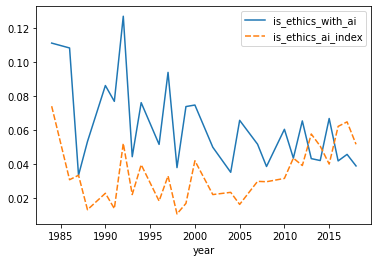

In [110]:
sns.lineplot(data=aaai_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean())

In [112]:
nips_data = pd.read_csv("nips.txt", sep=";", quotechar="#", header=0, names=["year","id","title","authors","link","abstract"])
nips_data = nips_data[nips_data["abstract"].notna()]

In [113]:
nips_docs = []
for doc in nlp.pipe(nips_data.abstract):
    nips_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [114]:
nips_X = vectorizer.transform(nips_docs)
nips_y_pred = rf_pipeline.predict(nips_X)
nips_y_prob = rf_pipeline.predict_proba(nips_X)

In [115]:
nips_data["is_ethics_with_ai"] = nips_y_pred

In [116]:
nips_ai_index_pred = []
for doc in nips_data.abstract:
    nips_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [117]:
nips_data["is_ethics_ai_index"] = nips_ai_index_pred

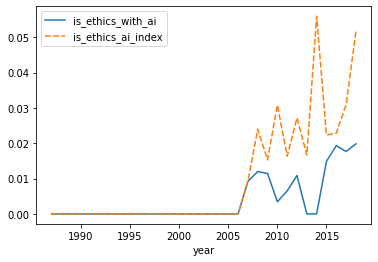

In [118]:
sns.lineplot(data=nips_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean())

In [119]:
aaai_data["conf"] = "aaai"
nips_data["conf"] = "nips"

In [146]:
a = aaai_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean()
n = nips_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean()

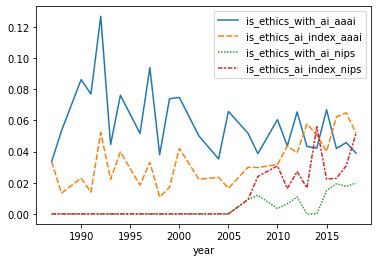

In [147]:
sns.lineplot(data=pd.merge(a,n, on="year", suffixes=("_aaai","_nips")))

In [219]:
cdblp = pd.read_csv("cdblp.csv", sep="\t", quotechar='"', header=1, names=["key","title","booktitle","year","ee","empty"]).drop("empty", axis=1)

In [220]:
def ai_conf(v):
    return v.upper() in ["AAAI","IJCAI","NIPS","ICML"]

def robotics_conf(v):
    return v.upper() in ["ICRA","IROS"]

In [221]:
cdblp["conftype"] = None
cdblp["conftype"][cdblp.booktitle.apply(ai_conf)] = "AI"
cdblp["conftype"][cdblp.booktitle.apply(robotics_conf)] = "Robotics"
cdblp["conftype"][cdblp["conftype"].isna()] = cdblp.booktitle[cdblp["conftype"].isna()]

/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [244]:
filtered_cdblp = cdblp[np.logical_or(cdblp.conftype=="AI",cdblp.conftype=="Robotics")]
filtered_cdblp = filtered_cdblp[filtered_cdblp.title.notna()]

In [245]:
cdblp_docs = []
for doc in nlp.pipe(filtered_cdblp.title):
    cdblp_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))
cdblp_y_pred = rf_pipeline.predict(vectorizer.transform(cdblp_docs))

cdblp_ai_index_pred = []
for doc in filtered_cdblp.title:
    cdblp_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [368]:
filtered_cdblp["is_ethics_with_ai"] = cdblp_y_pred
filtered_cdblp["is_ethics_ai_index"] = cdblp_ai_index_pred

In [377]:
list(filtered_cdblp[np.logical_and(filtered_cdblp.year==2000, filtered_cdblp.booktitle=="AAAI")].title)

['An ILP Method Based on Instance Graph.',
 'Artificial Intelligence-Based Computer Modeling Tools for Controlling Slag Foaming in Electric Furnaces.',
 'Mixed-Initiative Reasoning for Integrated Domain Modeling, Learning and Problem Solving.',
 'Ontology Integration in XML.']

In [343]:
cdf = filtered_cdblp[["year","booktitle","is_ethics_with_ai", "is_ethics_ai_index"]].groupby(["year","booktitle"]).mean().reset_index()

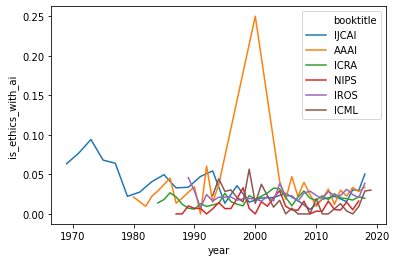

In [291]:
sns.lineplot(data=cdf, x="year", y="is_ethics_with_ai", hue="booktitle")

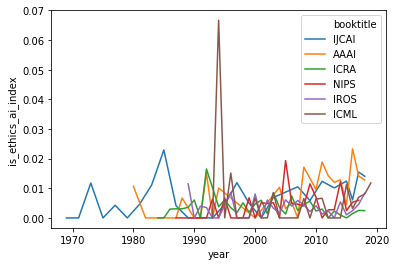

In [292]:
sns.lineplot(data=cdf, x="year", y="is_ethics_ai_index", hue="booktitle")

In [342]:
cdf.to_csv("conference.csv")

In [361]:
years = sorted(list(set(map(int,cdf.year))))
confs = sorted(list(set(cdf.booktitle)))
values = {}
for i in cdf.index:
    y = int(cdf.year[i])
    conf = cdf.booktitle[i]
    values[(y,conf)] = cdf.is_ethics_with_ai[i]

print("year".format(y),end="")
for c in confs:
    print(" & {}".format(c),end="")
print("\\\\")
for y in years:
    print("{}".format(y),end="")
    for c in confs:
        if (y,c) in values:
            val = "{:.3f}".format(values[(y,c)])
        else:
            val = "-"
        print(" & {}".format(val),end="")
    print("\\\\")

year & AAAI & ICML & ICRA & IJCAI & IROS & NIPS\\
1969 & - & - & - & 0.063 & - & -\\
1971 & - & - & - & 0.077 & - & -\\
1973 & - & - & - & 0.094 & - & -\\
1975 & - & - & - & 0.068 & - & -\\
1977 & - & - & - & 0.064 & - & -\\
1979 & - & - & - & 0.022 & - & -\\
1980 & 0.021 & - & - & - & - & -\\
1981 & - & - & - & 0.028 & - & -\\
1982 & 0.010 & - & - & - & - & -\\
1983 & 0.022 & - & - & 0.041 & - & -\\
1984 & 0.029 & - & 0.014 & - & - & -\\
1985 & - & - & 0.018 & 0.050 & - & -\\
1986 & 0.045 & - & 0.027 & - & - & -\\
1987 & 0.014 & - & 0.021 & 0.033 & - & 0.000\\
1988 & 0.020 & - & 0.012 & - & - & 0.000\\
1989 & - & - & 0.007 & 0.034 & 0.046 & 0.010\\
1990 & 0.034 & - & 0.006 & - & 0.029 & 0.007\\
1991 & 0.000 & - & 0.013 & 0.047 & 0.008 & 0.007\\
1992 & 0.061 & - & 0.009 & - & 0.024 & 0.000\\
1993 & 0.015 & 0.023 & - & 0.054 & 0.016 & 0.006\\
1994 & 0.037 & 0.044 & 0.013 & - & 0.021 & 0.014\\
1995 & - & 0.029 & 0.026 & 0.014 & - & 0.007\\
1996 & - & 0.030 & 0.015 & - & 0.021 & 0.007\\
1

In [230]:
jdblp = pd.read_csv("jdblp.csv", sep="\t", quotechar='"', header=1, names=["key","title","journal","volume","year","ee","empty"]).drop("empty", axis=1)

In [307]:
def infix_of(v,confs):
    return any(c.lower() in v.lower()  for c in confs)

def ieee_trans_ai(v):
    confs = ["IEEE Trans. Affective", "IEEE Trans. Audio, Speech", "IEEE Trans.Cognitive", "IEEE Trans. Comput. Intellig.", "IEEE Trans.Emerging Topics in Comput. Intellig", "IEEE Trans. Fuzzy Systems", "IEEE Trans. Intelligent", "IEEE Trans. Neural"]
    return infix_of(v,confs)

def ieee_trans_robotics(v):
    confs = ["IEEE Trans. Automat.", "IEEE Trans. Automation", "IEEE Trans. Robotics"]
    return infix_of(v,confs)

def ieee_trans(v):
    confs = ["IEEE Trans."]
    return infix_of(v,confs)

def acm_trans(v):
    confs = ["ACM Trans."]
    return infix_of(v,confs)


In [332]:
jdblp["journaltype"] = None
jdblp["journaltype"][jdblp.journal.apply(ieee_trans)] = "IEEE Trans."
jdblp["journaltype"][jdblp.journal.apply(ieee_trans_ai)] = "IEEE Trans. (AI)"
jdblp["journaltype"][jdblp.journal.apply(ieee_trans_robotics)] = "IEEE Trans. Robotics"
jdblp["journaltype"][jdblp.journal.apply(acm_trans)] = "ACM Trans."
jdblp["journaltype"][jdblp.journal=="J. Artif. Intell. Res."] = "J. Artif. Intell. Res."
jdblp["journaltype"][jdblp.journal=="IEEE Computer"] = "IEEE Computer"

/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/phcavelar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [334]:
filtered_jdblp = jdblp[jdblp.journaltype.notna()]
filtered_jdblp = filtered_jdblp[filtered_jdblp.title.notna()]

In [314]:
jdblp_docs = []
for doc in nlp.pipe(filtered_jdblp.title):
    jdblp_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))
jdblp_y_pred = rf_pipeline.predict(vectorizer.transform(jdblp_docs))

jdblp_ai_index_pred = []
for doc in filtered_jdblp.title:
    jdblp_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [378]:
filtered_jdblp["is_ethics_with_ai"] = jdblp_y_pred
filtered_jdblp["is_ethics_ai_index"] = jdblp_ai_index_pred

In [385]:
filtered_jdblp[np.logical_and(filtered_jdblp.is_ethics_with_ai,np.logical_and(filtered_jdblp.journaltype=="IEEE Computer", filtered_jdblp.year==2011))]

,key,title,journal,volume,year,ee,journaltype,is_ethics_with_ai,is_ethics_ai_index
223562,journals/computer/BreznitzMG11,Ubiquitous Data Collection: Rethinking Privacy...,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.192,IEEE Computer,1,1
225145,journals/computer/ZhangGY11,The Emergence of Social and Community Intellig...,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.65,IEEE Computer,1,0
226763,journals/computer/NutiMTY11,Algorithmic Trading.,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.31,IEEE Computer,1,0


In [379]:
jdf = filtered_jdblp[["year","journaltype","is_ethics_with_ai", "is_ethics_ai_index"]].groupby(["year","journaltype"]).mean().reset_index()

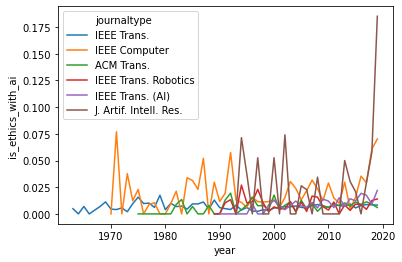

In [380]:
sns.lineplot(data=jdf, x="year", y="is_ethics_with_ai", hue="journaltype")

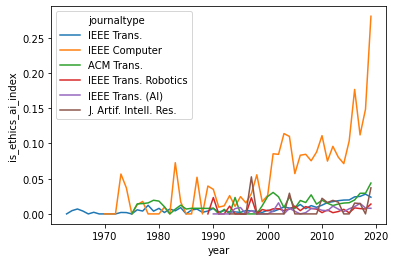

In [381]:
sns.lineplot(data=jdf, x="year", y="is_ethics_ai_index", hue="journaltype")

In [386]:
years = sorted(list(set(map(int,jdf.year))))
confs = sorted(list(set(jdf.journaltype)))
values = {}
for i in jdf.index:
    y = int(jdf.year[i])
    conf = jdf.journaltype[i]
    values[(y,conf)] = jdf.is_ethics_with_ai[i]

print("year".format(y),end="")
for c in confs:
    print(" & {}".format(c),end="")
print("\\\\")
for y in years:
    print("{}".format(y),end="")
    for c in confs:
        if (y,c) in values:
            val = "{:.3f}".format(values[(y,c)])
        else:
            val = "-"
        print(" & {}".format(val),end="")
    print("\\\\")


year & ACM Trans. & IEEE Computer & IEEE Trans. & IEEE Trans. (AI) & IEEE Trans. Robotics & J. Artif. Intell. Res.\\
1963 & - & - & 0.005 & - & - & -\\
1964 & - & - & 0.000 & - & - & -\\
1965 & - & - & 0.007 & - & - & -\\
1966 & - & - & 0.000 & - & - & -\\
1967 & - & - & 0.004 & - & - & -\\
1968 & - & - & 0.007 & - & - & -\\
1969 & - & - & 0.011 & - & - & -\\
1970 & - & 0.000 & 0.004 & - & - & -\\
1971 & - & 0.077 & 0.004 & - & - & -\\
1972 & - & 0.000 & 0.006 & - & - & -\\
1973 & - & 0.038 & 0.002 & - & - & -\\
1974 & - & 0.012 & 0.010 & - & - & -\\
1975 & 0.000 & 0.023 & 0.016 & - & - & -\\
1976 & 0.000 & 0.000 & 0.010 & - & - & -\\
1977 & 0.000 & 0.009 & 0.010 & - & - & -\\
1978 & 0.000 & 0.010 & 0.006 & - & - & -\\
1979 & 0.000 & 0.000 & 0.018 & - & - & -\\
1980 & 0.000 & 0.000 & 0.004 & - & - & -\\
1981 & 0.000 & 0.010 & 0.010 & - & - & -\\
1982 & 0.009 & 0.021 & 0.007 & - & - & -\\
1983 & 0.014 & 0.000 & 0.007 & - & - & -\\
1984 & 0.000 & 0.034 & 0.004 & - & - & -\\
1985 & 0.007 

In [382]:
jdf.to_csv("journal.csv")